# Major Project: Living Thing Classification

Nottachat Kaewgard

Student ID: 47369833

Kaggle: melnottachat

The task is to work with a dataset of images of living things and predict the category label of the living thing.  Category labels will be predicted at two different levels of granularity in the Linnaean taxonomy of living things, one more coarse-grained and one more fine-grained.

# Preparation

## Setup Environment

In [32]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
import xgboost
import lightgbm

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

import warnings
warnings.filterwarnings('ignore')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.0
Keras Version: 2.12.0
GPU is available


In [2]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('public')

In [3]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y

## Import Data

In [4]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [5]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


### Create datasets for Conventional Machine Learning

The dataset is quite extensive, consisting of 100,000 training images, 50,000 validation images and 50,000 testing images. A portion (20%) of these datasets will be utilized to train and test the model.

In [6]:
X,Y = create_dataset_sklearn('train', fine_grained=False, percent=0.2)
X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, percent=0.2)
X_test, Y_test = create_dataset_sklearn('test', fine_grained=False, percent=1.0)

Metal device set to: Apple M1 Max


2023-05-26 17:20:57.021063: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
print("Training Images: ", X.shape)
print("Testing Images: ", X_test.shape)
print("Validation Images: ", X_val.shape)

Training Images:  (20000, 2304)
Testing Images:  (50000, 2304)
Validation Images:  (10000, 2304)


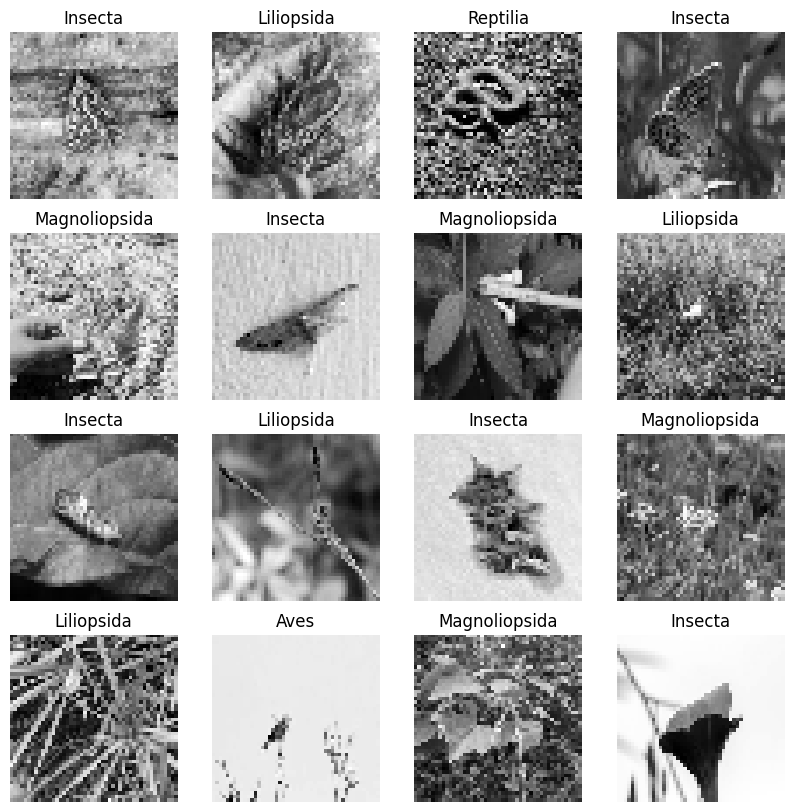

In [8]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

### Create datasets for Deep Learning

In [9]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=1000)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=1000)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=1000)

In [10]:
percent = 0.2
partial_train_ds = train_ds.take(int(len(train_ds) * percent))
partial_val_ds = val_ds.take(int(len(val_ds) * percent))

In [11]:
print("Training Images: ", len(partial_train_ds) * 1000)
print("Testing Images: ", len(test_ds) * 1000)
print("Validation Images: ", len(partial_val_ds) * 1000)

Training Images:  20000
Testing Images:  50000
Validation Images:  10000


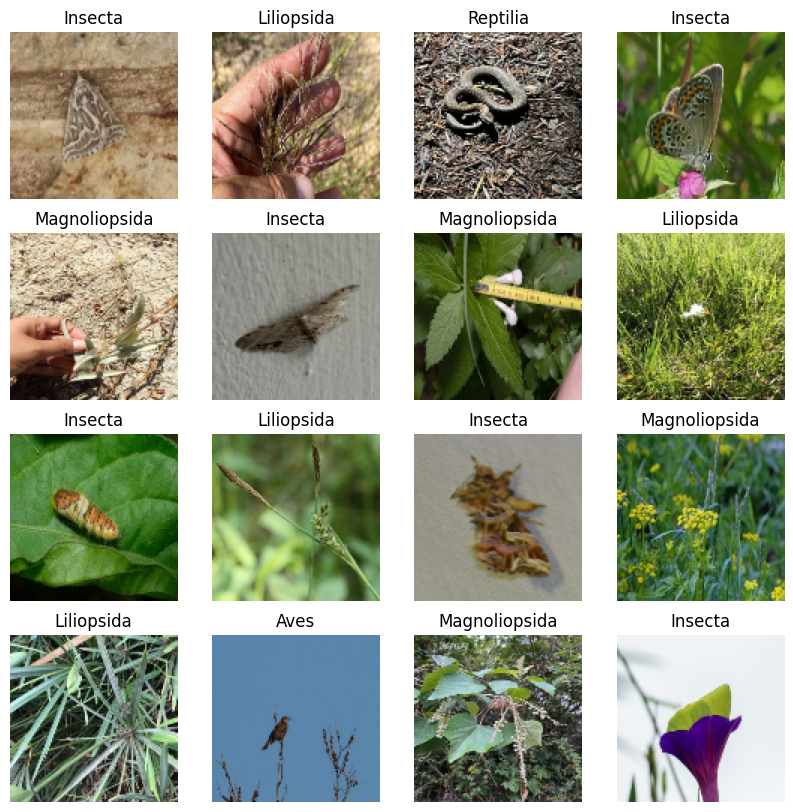

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in partial_train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

# Data Exploration

## Coarse-Grained Data

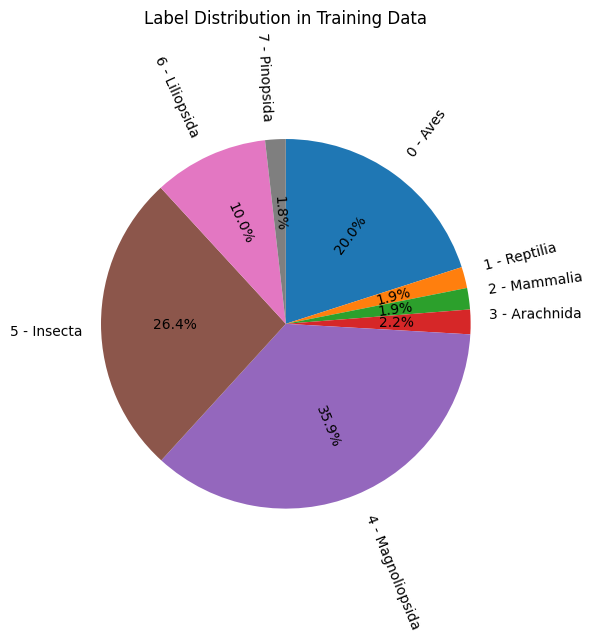

In [13]:
labels, counts = np.unique(Y, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(8), coarse_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Training Data", pad=50)
plt.show()

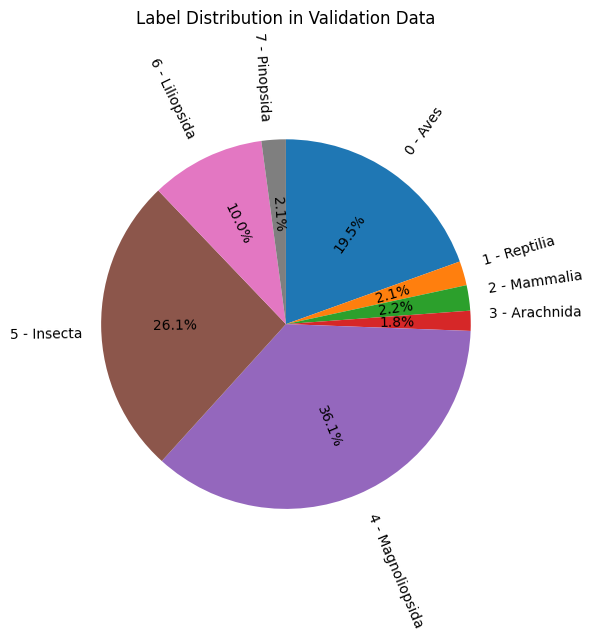

In [14]:
labels, counts = np.unique(Y_val, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(8), coarse_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Validation Data", pad=50)
plt.show()

### Observation

- The proportion of label indicating imbalance issue in the dataset. However, both training data and validation data have a similar proportion of labels so resampling is not needed on these datasets.

## Fine-Grained Data

In [141]:
fine_X,fine_Y = create_dataset_sklearn('train', fine_grained=True, percent=0.2)
fine_X_val,fine_Y_val = create_dataset_sklearn('val', fine_grained=True, percent=0.2)

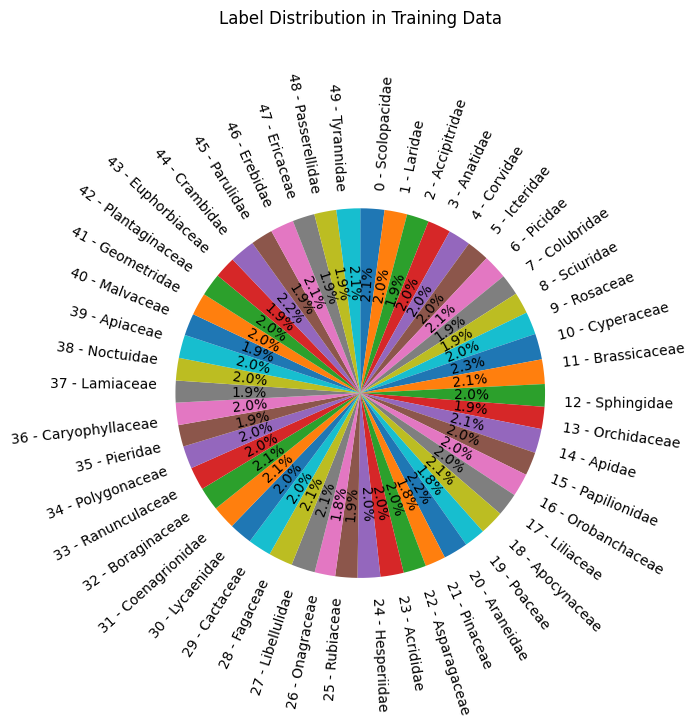

In [148]:
labels, counts = np.unique(fine_Y, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(len(fine_names)), fine_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Training Data", pad=100)
plt.show()

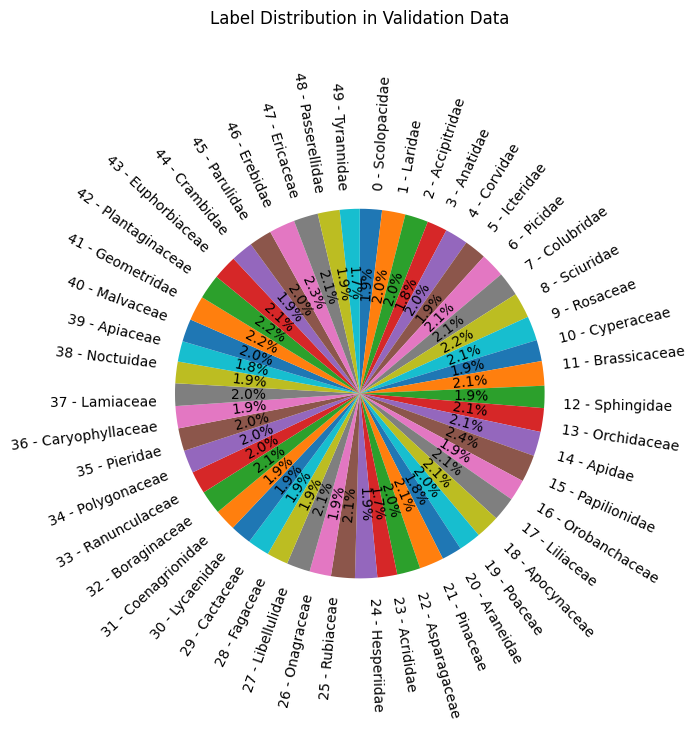

In [150]:
labels, counts = np.unique(fine_Y_val, return_counts = True)
plt.figure(figsize=(6,6))
patches, labels, pct_texts = plt.pie(
    counts, 
    labels = [f'{index} - {name}' for index, name in zip(np.arange(len(fine_names)), fine_names)], 
    autopct='%1.1f%%', 
    rotatelabels = True,
    startangle = 90,
    counterclock = False
)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title("Label Distribution in Validation Data", pad=100)
plt.show()

# Conventional Machine Learning

## Decision Tree Classifier

In [15]:
random_state = 5555
dt_clf = DecisionTreeClassifier(random_state = random_state)
dt_clf.fit(X, Y)

DecisionTreeClassifier(random_state=5555)

In [16]:
dt_train_pred = dt_clf.predict(X)
dt_train_accuracy = accuracy_score(Y, dt_train_pred)
print("Accuracy on Training Data: ", "{:.2%}".format(dt_train_accuracy))

Accuracy on Training Data:  100.00%


In [17]:
dt_val_pred = dt_clf.predict(X_val)
dt_val_accuracy = accuracy_score(Y_val, dt_val_pred)
print("Accuracy on Validation Data: ", "{:.2%}".format(dt_val_accuracy))

Accuracy on Validation Data:  30.91%


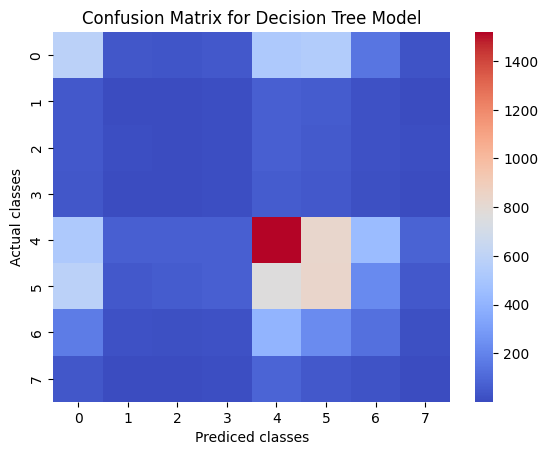

In [51]:
dt_cm = confusion_matrix(Y_val, dt_val_pred)
sns.heatmap(dt_cm, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

In [19]:
print(classification_report(Y_val, dt_val_pred))

              precision    recall  f1-score   support

           0       0.29      0.30      0.29      1950
           1       0.01      0.00      0.01       212
           2       0.03      0.03      0.03       222
           3       0.03      0.05      0.04       175
           4       0.44      0.42      0.43      3613
           5       0.32      0.32      0.32      2614
           6       0.13      0.13      0.13      1001
           7       0.03      0.02      0.02       213

    accuracy                           0.31     10000
   macro avg       0.16      0.16      0.16     10000
weighted avg       0.31      0.31      0.31     10000



## Random Forest Classifier

In [20]:
rf_clf = RandomForestClassifier(random_state = random_state)
rf_clf.fit(X, Y)

RandomForestClassifier(random_state=5555)

In [21]:
rf_train_pred = rf_clf.predict(X)
rf_train_accuracy = accuracy_score(Y, rf_train_pred)
print("Accuracy on Training Data: ", "{:.2%}".format(rf_train_accuracy))

Accuracy on Training Data:  100.00%


In [47]:
rf_val_pred = rf_clf.predict(X_val)
rf_val_accuracy = accuracy_score(Y_val, rf_val_pred)
print("Accuracy on Validation Data: ", "{:.2%}".format(rf_val_accuracy))

Accuracy on Validation Data:  47.69%


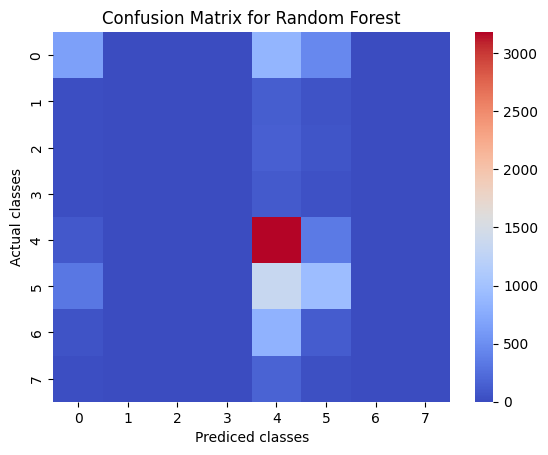

In [52]:
rf_cm = confusion_matrix(Y_val, rf_val_pred)
sns.heatmap(rf_cm, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [41]:
print(classification_report(Y_val, rf_val_pred))

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1950
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       222
           3       0.00      0.00      0.00       175
           4       0.47      0.88      0.61      3613
           5       0.46      0.36      0.40      2614
           6       0.50      0.00      0.00      1001
           7       0.00      0.00      0.00       213

    accuracy                           0.48     10000
   macro avg       0.25      0.20      0.18     10000
weighted avg       0.45      0.48      0.41     10000



## XGBoost Classifier

In [26]:
xgb_clf = xgboost.XGBClassifier(
    objective = "multi:softmax", 
    num_class = len(coarse_names), 
    random_state = random_state
)
xgb_clf.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [27]:
xgb_train_pred = xgb_clf.predict(X)
xgb_train_accuracy = accuracy_score(Y, xgb_train_pred)
print("Accuracy on Training Data: ", "{:.2%}".format(xgb_train_accuracy))

Accuracy on Training Data:  99.55%


In [28]:
xgb_val_pred = xgb_clf.predict(X_val)
xgb_val_accuracy = accuracy_score(Y_val, xgb_val_pred)
print("Accuracy on Validation Data: ", "{:.2%}".format(xgb_val_accuracy))

Accuracy on Validation Data:  49.89%


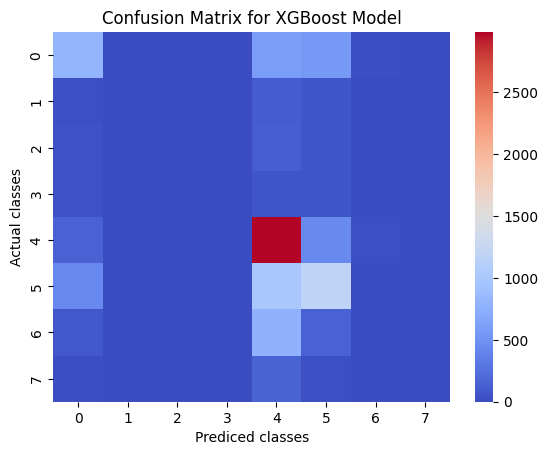

In [53]:
xgb_cm = confusion_matrix(Y_val, xgb_val_pred)
sns.heatmap(xgb_cm, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

In [44]:
print(classification_report(Y_val, xgb_val_pred))

              precision    recall  f1-score   support

           0       0.51      0.41      0.45      1950
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       222
           3       0.67      0.01      0.02       175
           4       0.52      0.83      0.64      3613
           5       0.46      0.45      0.46      2614
           6       0.14      0.01      0.02      1001
           7       0.80      0.02      0.04       213

    accuracy                           0.50     10000
   macro avg       0.39      0.22      0.20     10000
weighted avg       0.45      0.50      0.44     10000



## LightGBM

In [33]:
light_clf = lightgbm.LGBMClassifier(random_state = random_state)
light_clf.fit(X, Y)

LGBMClassifier(random_state=5555)

In [34]:
lgbm_train_pred = light_clf.predict(X)
lgbm_train_accuracy = accuracy_score(Y, lgbm_train_pred)
print("Accuracy on Training Data: ", "{:.2%}".format(lgbm_train_accuracy))

Accuracy on Training Data:  94.55%


In [36]:
lgbm_val_pred = light_clf.predict(X_val)
lgbm_val_accuracy = accuracy_score(Y_val, lgbm_val_pred)
print("Accuracy on Validation Data: ", "{:.2%}".format(lgbm_val_accuracy))

Accuracy on Validation Data:  50.50%


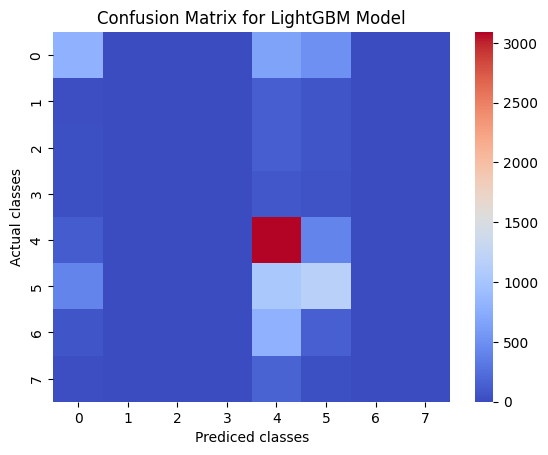

In [54]:
lgbm_cm = confusion_matrix(Y_val, lgbm_val_pred)
sns.heatmap(lgbm_cm, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()

In [46]:
print(classification_report(Y_val, lgbm_val_pred))

              precision    recall  f1-score   support

           0       0.53      0.41      0.46      1950
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       222
           3       0.17      0.01      0.01       175
           4       0.51      0.86      0.64      3613
           5       0.48      0.44      0.46      2614
           6       0.07      0.00      0.00      1001
           7       1.00      0.02      0.05       213

    accuracy                           0.51     10000
   macro avg       0.35      0.22      0.20     10000
weighted avg       0.45      0.51      0.44     10000



## Compare performances of conventional machine learning

In [48]:
conv_performance = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Training Accuracy': [dt_train_accuracy, rf_train_accuracy, xgb_train_accuracy, lgbm_train_accuracy],
    'Validation Accuracy': [dt_val_accuracy, rf_val_accuracy, xgb_val_accuracy, lgbm_val_accuracy]
});

conv_performance

,Model,Training Accuracy,Validation Accuracy
0,Decision Tree,1.00000,0.3091
1,Random Forest,1.00000,0.4769
2,XGBoost,0.99550,0.4989
3,LightGBM,0.94545,0.5050


### Observation

- The results show that, using the default configuration, LightGBM outperforms other conventional machine learning models.

- It is worth mentioning that all models exhibit signs of overfitting.

- According to the classification report, all models failed to accurately predict four labels: 1 - Reptilia, 2 - Mammalia, 3 - Arachnida, and 7 - Pinopsida. The recall ratios for these labels were almost zero, indicating that the models were unable to correctly identify instances of these classes. This is likely due to the scarcity of these labels in the dataset, as shown in the Data Exploratory section

- LightGBM is more efficient in terms of execution time and has the highest accuracy among the models tested. As a result, it has been chosen as the model for this task and will be fine-tuned in the next step.

## Performance Tuning

### LightGBM

In [104]:
light_clf2 = lightgbm.LGBMClassifier(
    random_state = random_state,
    num_leaves = 100, #default 31 
    num_iterations = 500, # default 100
    boosting = 'dart', # default SGD
    num_class = len(coarse_names),
    objective = 'multiclass'
)

light_clf2.fit(X, Y)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


LGBMClassifier(boosting='dart', num_class=8, num_iterations=500, num_leaves=100,
               objective='multiclass', random_state=5555)

In [105]:
lgbm_train_pred_2 = light_clf2.predict(X)
lgbm_train_accuracy_2 = accuracy_score(Y, lgbm_train_pred_2)
print("Accuracy on Training Data", "{:.2%}".format(lgbm_train_accuracy_2))

Accuracy on Training Data 100.00%


In [106]:
lgbm_val_pred_2 = light_clf2.predict(X_val)
lgbm_val_accuracy_2 = accuracy_score(Y_val, lgbm_val_pred_2)
print("Accuracy on Validation Data", "{:.2%}".format(lgbm_val_accuracy_2))

Accuracy on Validation Data 51.82%


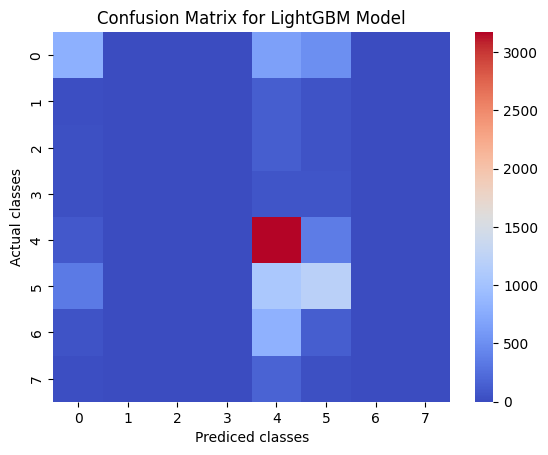

In [107]:
lgbm_cm_2 = confusion_matrix(Y_val, lgbm_val_pred_2)
sns.heatmap(lgbm_cm_2, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()

In [108]:
print(classification_report(Y_val, lgbm_val_pred_2))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48      1950
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       222
           3       0.50      0.01      0.01       175
           4       0.51      0.88      0.65      3613
           5       0.50      0.46      0.48      2614
           6       0.33      0.00      0.00      1001
           7       1.00      0.00      0.01       213

    accuracy                           0.52     10000
   macro avg       0.43      0.22      0.20     10000
weighted avg       0.49      0.52      0.45     10000



#### Coarse-Grained Data Set

##### Train the tuned model with a full dataset

In [109]:
X_full,Y_full = create_dataset_sklearn('train', fine_grained=False, percent=1)
X_val_full, Y_val_full = create_dataset_sklearn('val', fine_grained=False, percent=1)

In [110]:
light_clf2.fit(X_full, Y_full)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


LGBMClassifier(boosting='dart', num_class=8, num_iterations=500, num_leaves=100,
               objective='multiclass', random_state=5555)

In [111]:
lgbm_train_pred_f = light_clf2.predict(X_full)
lgbm_train_accuracy_f = accuracy_score(Y_full, lgbm_train_pred_f)
print("Accuracy on Training Data", "{:.2%}".format(lgbm_train_accuracy_f))

Accuracy on Training Data 96.11%


In [112]:
lgbm_val_pred_f = light_clf2.predict(X_val_full)
lgbm_val_accuracy_f = accuracy_score(Y_val_full, lgbm_val_pred_f)
print("Accuracy on Validation Data", "{:.2%}".format(lgbm_val_accuracy_f))

Accuracy on Validation Data 53.67%


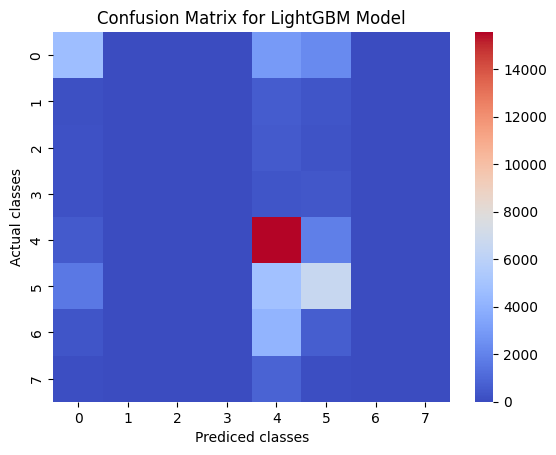

In [113]:
lgbm_cm_f = confusion_matrix(Y_val_full, lgbm_val_pred_f)
sns.heatmap(lgbm_cm_f, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()

In [116]:
print(classification_report(Y_val_full, lgbm_val_pred_f))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53      9935
           1       0.00      0.00      0.00      1049
           2       0.00      0.00      0.00       993
           3       1.00      0.00      0.00       928
           4       0.52      0.87      0.65     17969
           5       0.53      0.51      0.52     13006
           6       0.43      0.00      0.00      5075
           7       0.67      0.01      0.03      1045

    accuracy                           0.54     50000
   macro avg       0.47      0.23      0.22     50000
weighted avg       0.52      0.54      0.47     50000



##### Make a prediction on Coarse-grained test data

In [119]:
lgbm_coarse_pred = light_clf2.predict(X_test)

Next step is to store model predictions in a csv file.

In [128]:
coarse_test_csv = pd.read_csv(f"{root}/test.csv")
coarse_test_csv.loc[:, "coarse"] = lgbm_coarse_pred
coarse_test_csv = coarse_test_csv.drop(columns=['fine'])

coarse_pred_file = "47369833-conv-lgbm.csv"
coarse_test_csv.to_csv(coarse_pred_file, index = False)

#### Fine-Grained Data Set

In [130]:
X_fine,Y_fine = create_dataset_sklearn('train', fine_grained=True, percent=1)
X_val_fine, Y_val_fine = create_dataset_sklearn('val', fine_grained=True, percent=1)
X_test_fine, Y_test_fine = create_dataset_sklearn('test', fine_grained=True, percent=1)

##### Reconfigure the model for fine-grained dataset

In [131]:
light_clf_fine = lightgbm.LGBMClassifier(
    random_state = random_state,
    num_leaves = 100, #default 31 
    num_iterations = 500, # default 100
    boosting = 'dart', # default SGD
    num_class = len(fine_names),
    objective = 'multiclass'
)

##### Train the model with a full dataset

In [132]:
light_clf_fine.fit(X_fine, Y_fine)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


LGBMClassifier(boosting='dart', num_class=50, num_iterations=500,
               num_leaves=100, objective='multiclass', random_state=5555)

In [133]:
lgbm_fine_train_pred = light_clf_fine.predict(X_fine)
lgbm_fine_train_accuracy = accuracy_score(Y_fine, lgbm_fine_train_pred)
print("Accuracy on Training Data", "{:.2%}".format(lgbm_fine_train_accuracy))

Accuracy on Training Data 100.00%


In [134]:
lgbm_fine_val_pred = light_clf_fine.predict(X_val_fine)
lgbm_fine_val_accuracy = accuracy_score(Y_val_fine, lgbm_fine_val_pred)
print("Accuracy on Validation Data", "{:.2%}".format(lgbm_fine_val_accuracy))

Accuracy on Validation Data 10.25%


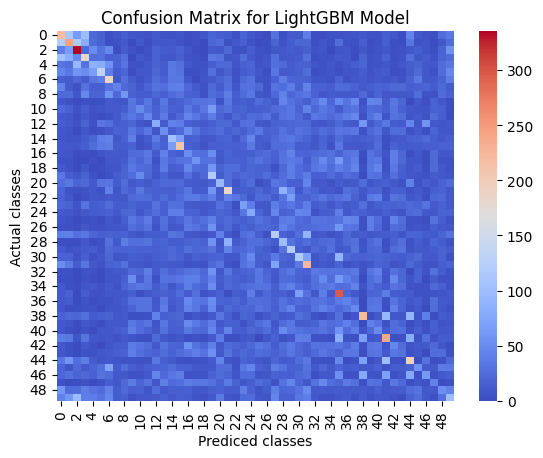

In [135]:
lgbm_cm_fine = confusion_matrix(Y_val_fine, lgbm_fine_val_pred)
sns.heatmap(lgbm_cm_fine, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel("Prediced classes")
plt.ylabel("Actual classes")
plt.title("Confusion Matrix for LightGBM Model")
plt.show()

In [151]:
print(classification_report(Y_val_fine, lgbm_fine_val_pred))

              precision    recall  f1-score   support

           0       0.17      0.22      0.19       981
           1       0.21      0.25      0.22       997
           2       0.30      0.34      0.32       981
           3       0.16      0.18      0.17       998
           4       0.12      0.09      0.10      1003
           5       0.16      0.14      0.15       979
           6       0.16      0.19      0.17       967
           7       0.08      0.04      0.05      1049
           8       0.07      0.06      0.06       993
           9       0.03      0.03      0.03       991
          10       0.06      0.05      0.05      1045
          11       0.05      0.04      0.05      1049
          12       0.09      0.08      0.08       991
          13       0.05      0.05      0.05       978
          14       0.10      0.10      0.10      1025
          15       0.17      0.20      0.18      1031
          16       0.04      0.05      0.05       956
          17       0.06    

##### Make a prediction on Fine-grained test data

In [137]:
lgbm_fine_pred = light_clf_fine.predict(X_test_fine)

Next step is to store model predictions in a csv file.

In [138]:
fine_test_csv = pd.read_csv(f"{root}/test.csv")
fine_test_csv.loc[:, "fine"] = lgbm_fine_pred
fine_test_csv = fine_test_csv.drop(columns=['coarse'])

fine_pred_file = "47369833-conv-lgbm-fine.csv"
fine_test_csv.to_csv(fine_pred_file, index = False)

# Deep Learning

In [152]:
train_ds = create_dataset_tf('train', fine_grained=False, batch_size=64, image_size = 384)
val_ds = create_dataset_tf('val', fine_grained=False, batch_size=64, image_size = 384)
test_ds = create_dataset_tf('test', fine_grained=False, batch_size=64, image_size = 384)

In [153]:
efficientnet_v2_s = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2"

In [155]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_s, trainable = False, name ="EfficientNetV2_s")


ENV2_s_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(384, 384, 3)),
    base_model,
    tf.keras.layers.Dense(8, activation="softmax", name="pred")
])

In [156]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate)
ENV2_s_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_s_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_s (KerasLaye  (None, 1280)             20331360  
 r)                                                              
                                                                 
 pred (Dense)                (None, 8)                 10248     
                                                                 
Total params: 20,341,608
Trainable params: 10,248
Non-trainable params: 20,331,360
_________________________________________________________________


In [157]:
ENV2_s_model_history = ENV2_s_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 940s 596ms/step - loss: 0.5168 - accuracy: 0.8924 - val_loss: 0.5565 - val_accuracy: 0.9045
Epoch 2/10
1563/1563 [==============================] - 926s 593ms/step - loss: 0.5128 - accuracy: 0.9024 - val_loss: 0.6369 - val_accuracy: 0.9009
Epoch 3/10
1563/1563 [==============================] - 926s 593ms/step - loss: 0.5091 - accuracy: 0.9060 - val_loss: 0.6492 - val_accuracy: 0.9050
Epoch 4/10
1563/1563 [==============================] - 926s 592ms/step - loss: 0.4997 - accuracy: 0.9079 - val_loss: 0.7273 - val_accuracy: 0.9020
Epoch 5/10
1563/1563 [==============================] - 925s 592ms/step - loss: 0.5073 - accuracy: 0.9084 - val_loss: 0.7326 - val_accuracy: 0.9024
Epoch 6/10
1563/1563 [==============================] - 925s 592ms/step - loss: 0.5006 - accuracy: 0.9091 - val_loss: 0.7662 - val_accuracy: 0.9024
Epoch 7/10
1563/1563 [==============================] - 926s 593ms/step - loss: 0.5052 - accuracy: 0.9093 - val_

In [158]:
ENV2_s_pred = ENV2_s_model.predict(test_ds)

782/782 [==============================] - 311s 393ms/step


In [159]:
ENV2_s_pred_class = ENV2_s_pred.argmax(axis=1)
ENV2_s_pred_class

array([6, 2, 6, ..., 0, 7, 7])

In [160]:
test_csv = pd.read_csv(f"{root}/test.csv")
test_csv.loc[:, "coarse"] = ENV2_s_pred_class
test_csv = test_csv.drop(columns=['fine'])

pred_file = "47369833-conv-ENV2_s2.csv"
test_csv.to_csv(pred_file, index = False)

In [161]:
ENV2_s_model.save('ENV2_ft1k_s_model')

INFO:tensorflow:Assets written to: ENV2_ft1k_s_model/assets


INFO:tensorflow:Assets written to: ENV2_ft1k_s_model/assets


In [162]:
train_ds = create_dataset_tf('train', fine_grained=False, batch_size=64, image_size = 480)
val_ds = create_dataset_tf('val', fine_grained=False, batch_size=64, image_size = 480)
test_ds = create_dataset_tf('test', fine_grained=False, batch_size=64, image_size = 480)

In [163]:
efficientnet_v2_l = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2"

In [166]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_l, trainable = False, name ="EfficientNetV2_l")


ENV2_l_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(480, 480, 3)),
    base_model,
    tf.keras.layers.Dense(8, activation="softmax", name="pred")
])

In [167]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate)
ENV2_l_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_l_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_l (KerasLaye  (None, 1280)             117746848 
 r)                                                              
                                                                 
 pred (Dense)                (None, 8)                 10248     
                                                                 
Total params: 117,757,096
Trainable params: 10,248
Non-trainable params: 117,746,848
_________________________________________________________________


In [169]:
ENV2_l_model_history = ENV2_l_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 4969s 3s/step - loss: 0.4489 - accuracy: 0.9217 - val_loss: 0.5292 - val_accuracy: 0.9259
Epoch 2/5
1563/1563 [==============================] - 4955s 3s/step - loss: 0.4470 - accuracy: 0.9272 - val_loss: 0.5350 - val_accuracy: 0.9279
Epoch 3/5
1563/1563 [==============================] - 4953s 3s/step - loss: 0.4403 - accuracy: 0.9298 - val_loss: 0.5969 - val_accuracy: 0.9265
Epoch 4/5
1563/1563 [==============================] - 4947s 3s/step - loss: 0.4365 - accuracy: 0.9307 - val_loss: 0.6364 - val_accuracy: 0.9263
Epoch 5/5
1563/1563 [==============================] - 4953s 3s/step - loss: 0.4333 - accuracy: 0.9320 - val_loss: 0.6457 - val_accuracy: 0.9273


In [170]:
ENV2_l_pred = ENV2_l_model.predict(test_ds)

782/782 [==============================] - 1662s 2s/step


In [171]:
ENV2_l_pred_class = ENV2_l_pred.argmax(axis=1)
ENV2_l_pred_class

array([6, 2, 5, ..., 0, 7, 7])

In [172]:
test_csv = pd.read_csv(f"{root}/test.csv")
test_csv.loc[:, "coarse"] = ENV2_l_pred_class
test_csv = test_csv.drop(columns=['fine'])

pred_file = "47369833-conv-ENV2_l.csv"
test_csv.to_csv(pred_file, index = False)

In [173]:
ENV2_l_model.save('ENV2_ft1k_l_model')

INFO:tensorflow:Assets written to: ENV2_ft1k_l_model/assets


INFO:tensorflow:Assets written to: ENV2_ft1k_l_model/assets


In [174]:
train_ds = create_dataset_tf('train', fine_grained=True, batch_size=64, image_size = 480)
val_ds = create_dataset_tf('val', fine_grained=True, batch_size=64, image_size = 480)
test_ds = create_dataset_tf('test', fine_grained=True, batch_size=64, image_size = 480)

In [175]:
efficientnet_v2_l = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2"

In [176]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_l, trainable = False, name ="EfficientNetV2_l")


ENV2_l_fine_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(480, 480, 3)),
    base_model,
    tf.keras.layers.Dense(len(fine_names), activation="softmax", name="pred")
])

In [177]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate)
ENV2_l_fine_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_l_fine_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_l (KerasLaye  (None, 1280)             117746848 
 r)                                                              
                                                                 
 pred (Dense)                (None, 50)                64050     
                                                                 
Total params: 117,810,898
Trainable params: 64,050
Non-trainable params: 117,746,848
_________________________________________________________________


In [178]:
# This section will took a very long time to run.
ENV2_L_fine_checkpoint = tf.keras.callbacks.ModelCheckpoint("ENV2_L_fine_checkpoints", save_weights_only = True)
ENV2_l_fine_model_history = ENV2_l_fine_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=2,
    callbacks=[ENV2_L_fine_checkpoint])

Epoch 1/2
1563/1563 [==============================] - 4996s 3s/step - loss: 2.0360 - accuracy: 0.6974 - val_loss: 2.2016 - val_accuracy: 0.7206
Epoch 2/2
1563/1563 [==============================] - 4961s 3s/step - loss: 1.8892 - accuracy: 0.7492 - val_loss: 2.3384 - val_accuracy: 0.7379


In [179]:
ENV2_l_pred_fine = ENV2_l_fine_model.predict(test_ds)

782/782 [==============================] - 1673s 2s/step


In [180]:
ENV2_l_pred_fine_class = ENV2_l_pred_fine.argmax(axis=1)
ENV2_l_pred_fine_class

array([19,  8, 10, ..., 48, 21, 21])

In [181]:
test_csv = pd.read_csv(f"{root}/test.csv")
test_csv.loc[:, "fine"] = ENV2_l_pred_fine_class
test_csv = test_csv.drop(columns=['coarse'])

pred_file = "47369833-conv-ENV2_l_fine.csv"
test_csv.to_csv(pred_file, index = False)

In [182]:
ENV2_l_model.save('ENV2_ft1k_l_fine_model')

INFO:tensorflow:Assets written to: ENV2_ft1k_l_fine_model/assets


INFO:tensorflow:Assets written to: ENV2_ft1k_l_fine_model/assets


In [183]:
train_ds = create_dataset_tf('train', fine_grained=False, batch_size=64, image_size = 512)
val_ds = create_dataset_tf('val', fine_grained=False, batch_size=64, image_size = 512)
test_ds = create_dataset_tf('test', fine_grained=False, batch_size=64, image_size = 512)

In [184]:
efficientnet_v2_xl = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2"

In [185]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_xl, trainable = False, name ="EfficientNetV2_xl")


ENV2_xl_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(512, 512, 3)),
    base_model,
    tf.keras.layers.Dense(8, activation="softmax", name="pred")
])

In [188]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate)
ENV2_xl_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_xl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_xl (KerasLay  (None, 1280)             207615832 
 er)                                                             
                                                                 
 pred (Dense)                (None, 8)                 10248     
                                                                 
Total params: 207,626,080
Trainable params: 10,248
Non-trainable params: 207,615,832
_________________________________________________________________


In [189]:
ENV2_xl_model_history = ENV2_xl_model.fit(train_ds, validation_data=val_ds, epochs=1)

1563/1563 [==============================] - 7837s 5s/step - loss: 0.2785 - accuracy: 0.9441 - val_loss: 0.3434 - val_accuracy: 0.9332


In [201]:
ENV2_xl_pred = ENV2_xl_model.predict(test_ds)

 45/782 [>.............................] - ETA: 47:52

KeyboardInterrupt: 

In [ ]:
ENV2_xl_pred_class = ENV2_xl_pred.argmax(axis=1)
ENV2_xl_pred_class

array([6, 2, 5, ..., 0, 7, 7])

In [ ]:
test_csv = pd.read_csv(f"{root}/test.csv")
test_csv.loc[:, "coarse"] = ENV2_xl_pred_class
test_csv = test_csv.drop(columns=['fine'])

pred_file = "47369833-conv-ENV2_xl.csv"
test_csv.to_csv(pred_file, index = False)

In [202]:
ENV2_xl_model.save('ENV2_ft1k_xl_model')

INFO:tensorflow:Assets written to: ENV2_ft1k_xl_model/assets


INFO:tensorflow:Assets written to: ENV2_ft1k_xl_model/assets


In [195]:
train_ds = create_dataset_tf('train', fine_grained=True, batch_size=64, image_size = 512)
val_ds = create_dataset_tf('val', fine_grained=True, batch_size=64, image_size = 512)
test_ds = create_dataset_tf('test', fine_grained=True, batch_size=64, image_size = 512)

In [235]:
efficientnet_v2_xl = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2"

In [236]:
tf.random.set_seed(42)
tf.keras.backend.clear_session() # extra code – resets layer name counter

base_model = hub.KerasLayer(efficientnet_v2_xl, trainable = False, name ="EfficientNetV2_xl")


ENV2_xl_fine_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(512, 512, 3)),
    base_model,
    tf.keras.layers.Dense(len(fine_names), activation="softmax", name="pred")
])

In [237]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate)
ENV2_xl_fine_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
ENV2_xl_fine_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2_xl (KerasLay  (None, 1280)             207615832 
 er)                                                             
                                                                 
 pred (Dense)                (None, 50)                64050     
                                                                 
Total params: 207,679,882
Trainable params: 64,050
Non-trainable params: 207,615,832
_________________________________________________________________


In [238]:
# This section will took a very long time to run.
ENV2_xl_fine_checkpoint = tf.keras.callbacks.ModelCheckpoint("ENV2_xl_fine_checkpoints", save_weights_only = True)
ENV2_xl_fine_model_history = ENV2_xl_fine_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=2,
    callbacks=[ENV2_xl_fine_checkpoint])

Epoch 1/2
1563/1563 [==============================] - 8375s 5s/step - loss: 1.4361 - accuracy: 0.6303 - val_loss: 7.9534 - val_accuracy: 0.0205
Epoch 2/2
 228/1563 [===>..........................] - ETA: 1:14:06 - loss: 0.9879 - accuracy: 0.7242

KeyboardInterrupt: 

In [ ]:
ENV2_xl_model.save('ENV2_ft1k_xl_fine_model')

INFO:tensorflow:Assets written to: ENV2_ft1k_l_fine_model/assets


INFO:tensorflow:Assets written to: ENV2_ft1k_l_fine_model/assets


In [ ]:
ENV2_xl_pred_fine = ENV2_xl_fine_model.predict(test_ds)

In [ ]:
ENV2_xl_pred_fine_class = ENV2_xl_pred_fine.argmax(axis=1)
ENV2_xl_pred_fine_class

array([19,  8, 10, ..., 48, 21, 21])

In [ ]:
test_csv = pd.read_csv(f"{root}/test.csv")
test_csv.loc[:, "fine"] = ENV2_xl_pred_fine_class
test_csv = test_csv.drop(columns=['coarse'])

pred_file = "47369833-conv-ENV2_xl_fine.csv"
test_csv.to_csv(pred_file, index = False)